<h1 style="font-family:verdana;"> <center>Cat or Dog Transfer Learning</center> </h1>
<p><center style="color:violet;font-size:30px"> Using pretrained ResNet-50 </center></p>

***

<a id = 'sec1'></a>
# Load Required Packages

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels.h5
/kaggle/input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
/kaggle/input/resnet50/imagenet_class_index.json
/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


In [3]:
import cv2
from tqdm import tqdm          #Used for the purpose of showing iterations getting loaded in bar kind of form
from random import shuffle
from zipfile import ZipFile
import glob
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

<a id = 'sec2'></a>
# Read the Data

We will unzip train and test directory using zipfile library.

In [4]:
zip_file = glob.glob('../input/dogs-vs-cats-redux-kernels-edition/*.zip')  #return any files with .zip extension
print(zip_file)

#extract file into a temp folder
def extract_zip(file):
    with ZipFile(file,'r') as zip_ref:
        zip_ref.extractall('.')
        
#extract both train and test1 zip
for files in zip_file:
    extract_zip(files)

['../input/dogs-vs-cats-redux-kernels-edition/train.zip', '../input/dogs-vs-cats-redux-kernels-edition/test.zip']


In [5]:
def get_path(directory):
    path = []
    for files in os.listdir(directory):
        path.append(files)
    return path

train_path = get_path('../working/train')
test_path = get_path('../working/test')

<a id = 'sec3'></a>
# Visualizing Data

In [6]:
#this labelling function is just for the visualization, we'll have separate one for preprocessing.
def label_img(img):
    category = img.split('.')[-3]
    if category == 'cat': return [1,0]
    elif category == 'dog': return [0,1]

#Process the data, here we're converting images into numpy array. This function takes image data, image directory, a boolean as an argument.
def process_data(img_data, data_dir, isTrain=True):
    data_df = []
    for img in tqdm(img_data):
        path = os.path.join(data_dir,img)         #Assigning path to images by concatenating directory and images
        if(isTrain):
            label = label_img(img)            #Calling label_img to assign labels to image present in training directory
        else:
            label = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224,224))
        data_df.append([np.array(img),np.array(label)])          #append image and labels as numpy array in data_df list
    shuffle(data_df)
    return data_df

In [7]:
#We will plot the images of dogs and cats and display the assigned label above image
def show_images(data, isTest=False):
    f, ax = plt.subplots(nrows = 5, ncols = 5, figsize = (15,15))
    for i,data in enumerate(data[:25]):              #enumerate helps in keeping track of count of iterations
        img_num = data[1]
        img_data = data[0]
        label = np.argmax(img_num)                    #to get maximum indices of an array
        if label  == 1: 
            str_label='Dog'
        elif label == 0: 
            str_label='Cat'
        if(isTest):
            str_label="None"
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis('off')                 #removing axis for better look
        ax[i//5, i%5].set_title("Label: {}".format(str_label))
    plt.show()

<a id = 'subsec2'></a>
<span style="color:green;font-size:20px"> Visualizing Training Set </span>

100%|██████████| 25000/25000 [00:55<00:00, 453.23it/s]


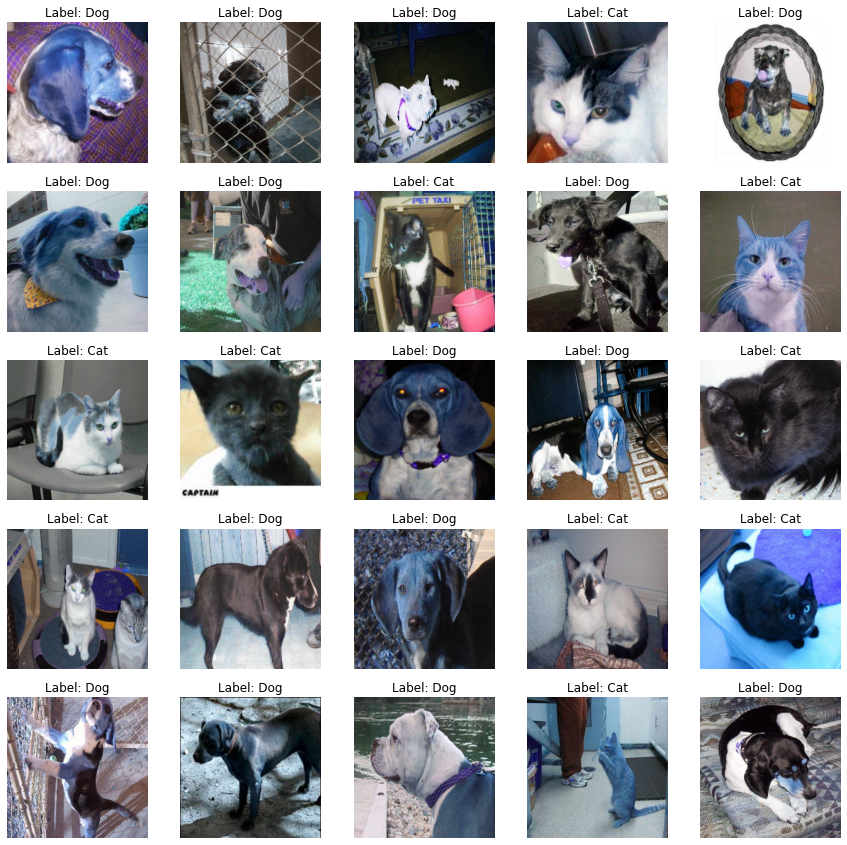

In [8]:
train = process_data(train_path, './train/')
show_images(train)

<a id = 'subsec3'></a>
<span style="color:green;font-size:20px"> Visualizing Test Set </span>

100%|██████████| 12500/12500 [00:27<00:00, 451.52it/s]


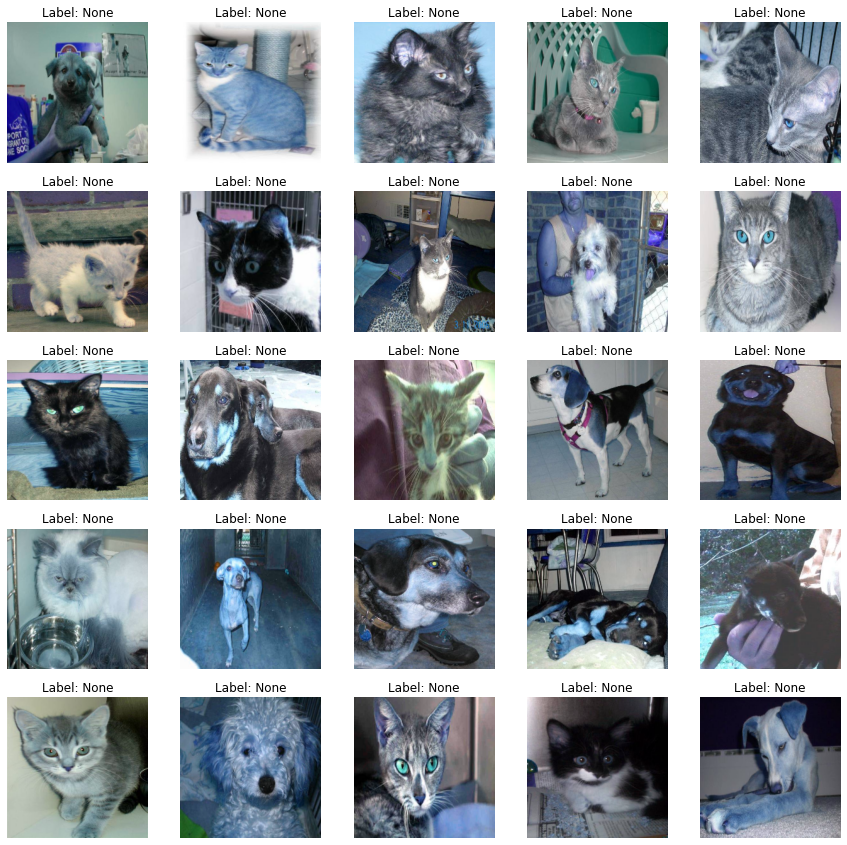

In [9]:
test = process_data(test_path, './test/', False)
show_images(test,True)

[Back to contents(click here)](#content)

<a id = 'sec4'></a>
# Preprocessing Data

In [10]:
#We will use below function to label data
def get_label(directory):
    label = []
    for file in os.listdir(directory):
        if (file.split('.')[0] == 'dog'):
            label.append(str(1))
        elif (file.split('.')[0] == 'cat'):
            label.append(str(0))
    return label

label = get_label('../working/train')

#In case of train_test_split, allowed inputs are lists, numpy arrays, scipy-sparse matrices or pandas dataframes. Convert the images and labels into dataframe.
df = pd.DataFrame({'filename': train_path, 'label': label})
df.head()

,filename,label
0,cat.4513.jpg,0
1,dog.11592.jpg,1
2,cat.11497.jpg,0
3,dog.9738.jpg,1
4,dog.12319.jpg,1


In [11]:
#split data into train and valid set
train_df, valid_df = train_test_split(df, test_size = 0.2, stratify = df['label'], random_state = 123)
print(train_df.shape)
print(valid_df.shape)

(20000, 2)
(5000, 2)


In [12]:
#We'll perform individually on train and validation set.
train_datagen = ImageDataGenerator(rotation_range = 10, zoom_range = 0.1, horizontal_flip = True, fill_mode = 'nearest', 
                                   width_shift_range = 0.1, height_shift_range = 0.1, preprocessing_function = preprocess_input)

#flow_from_dataframe() method will accept dataframe with filenames as x_column and labels as y_column to generate mini-batches
train_gen = train_datagen.flow_from_dataframe(train_df, directory = '../working/train', x_col = 'filename', y_col = 'label', target_size = (224,224),
                                              batch_size = 64, class_mode='binary')

#we do not augment validation data.
valid_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

valid_gen = valid_datagen.flow_from_dataframe(valid_df, directory = '../working/train', x_col = 'filename', y_col = 'label', target_size = (224,224),
                                              batch_size = 64, class_mode='binary')

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


<a id = 'sec5'></a>
# Model

In [13]:
model = Sequential()
model.add(ResNet50(include_top = False, pooling = 'max', weights = 'imagenet'))
model.add(Dense(1, activation = 'sigmoid'))

model.layers[0].trainable = False 

94773248/94765736 [==============================] - 1s 0us/step


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [15]:
model.compile(optimizer = 'adam', metrics = ['accuracy'], loss = 'binary_crossentropy')

In [16]:
checkpointer = ModelCheckpoint(filepath = 'dogcat.weights.best.hdf5', save_best_only = True, save_weights_only = True)

<a id = 'subsec22'></a>
<span style = 'color:pink;font-size:32px'> Train the model </span>

In [18]:
model.fit_generator(train_gen, epochs = 5, validation_data = valid_gen, callbacks = [checkpointer])

Epoch 1/5
232/313 [=====================>........] - ETA: 1:21 - loss: 0.0851 - accuracy: 0.9808

KeyboardInterrupt: 

Plot the loss and accuracy curves.

In [ ]:
loss = pd.DataFrame(model.history.history)
loss[['loss', 'val_loss']].plot()
loss[['accuracy', 'val_accuracy']].plot()

<a id = 'sec6'></a>
# Results

In [ ]:
#load the best weights saved using checkpointer
model.load_weights('dogcat.weights.best.hdf5')

In [ ]:
test_df = pd.DataFrame({'filename': test_path})    #test_path from function get_path

<a id = 'subsec31'></a>
<span style = 'color:pink;font-size:20px'> Visualizing Predictions </span>

We will use test dataframe generated above and process the image. We will predict class using 'model.predict' and append the labels in a list.

In [ ]:
test_sample = test_df.sample(n = 25, random_state = 123)    #Randomly sample 25 images from test directory for visualizing predictions

label_pred = []                         #list for predicted labels
for path in test_sample['filename'].to_numpy():
    full_path = '../working/test/'+path
    x = load_img(full_path, target_size=(224,224))
    img_array = img_to_array(x)
    img_array = np.expand_dims(img_array, axis=0)
    
    out =  model.predict(img_array)    
    out = 'Dog' if float(out) >0.5 else 'Cat'
    label_pred.append(out)

We will plot 25 random test images with their class using list of predicted labels.

In [ ]:
test_array = test_sample['filename'].to_numpy()            # convert dataframe to numpy array 

plt.figure(figsize=(15, 15))
for i in range(0, 25):
    plt.subplot(5, 5, i+1)
    img = test_array[i]
    path = '../working/test/' + img
    image = load_img(path, target_size=(256,256))
    
    plt.title('Predicted: {}'.format(label_pred[i]), color='green',fontsize= 10, bbox=dict(facecolor='black', alpha=0.7))
    plt.imshow(image)
    plt.axis('off')

plt.tight_layout()

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

test_gen = test_datagen.flow_from_dataframe(test_df, directory = '../working/test', batch_size = 64, x_col = 'filename', y_col = None, class_mode = None, shuffle = False,
                                            img_size = (224, 224))

In [ ]:
prediction = model.predict_generator(test_gen)
prediction = prediction.clip(min = 0.005, max = 0.995)     #use clip to set the minimum and maximum limit of predicted probabilities.